In this notebook we try to finetune GPT2-small
to match the behavior of a simple prompt over the tiny stories dataset.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import os

if os.uname().nodename == "ccg-gpu-0.csail.mit.edu":
    print("Running on CCG GPU")
    os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

from persona_convergence import tiny_stories, utils

DEVICE = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)
DEVICE

device(type='cuda')

### Load model

In [3]:
MODEL_ID = "gpt2"
model_base = GPT2LMHeadModel.from_pretrained(MODEL_ID).to(DEVICE).eval()
model_base.requires_grad_(False)
tokenizer: GPT2TokenizerFast = GPT2TokenizerFast.from_pretrained(MODEL_ID)

model_base.config.attn_pdrop

0.1

### Load dataset

In [4]:
SEQ_LEN = 128

ds_train = tiny_stories.load_ds(
    split="train[:1%]",
    tokenizer=tokenizer,
    seq_len=SEQ_LEN,
)
ds_val = tiny_stories.load_ds(
    split="validation",
    tokenizer=tokenizer,
    seq_len=SEQ_LEN,
)

Repo card metadata block was not found. Setting CardData to empty.


Map (num_proc=16):   0%|          | 0/21197 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/21197 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/20176 [00:00<?, ? examples/s]

Repo card metadata block was not found. Setting CardData to empty.


Map (num_proc=16):   0%|          | 0/21990 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/21990 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/20919 [00:00<?, ? examples/s]

### Test model behavior

In [5]:
n_new_tokens = 100
PREFIX = "This is a sad story."
prompt = " ".join(ds_train["text"][2].split(" ")[:32])

print("Prompt:")
utils.print_with_wrap(prompt)

print()
print("Continuation:")
utils.print_with_wrap(
    utils.gen_text(model_base, tokenizer, prompt, max_new_tokens=n_new_tokens)
)

print()
print(f"Continuation (prefix='{PREFIX} '):")
utils.print_with_wrap(
    utils.gen_text(
        model_base,
        tokenizer,
        PREFIX + " " + prompt,
        max_new_tokens=n_new_tokens,
    )
)

Prompt:
One day, a little fish named Fin was swimming near the shore. He saw a big crab
and wanted to be friends. "Hi, I am Fin. Do you want to play?" asked

Continuation:
 the fish. "I am Fin," said Fin. "I am Fin."  Fin was a big fish, but he was not
a big fish. He was a big fish. He was a big fish. He was a big fish. He was a
big fish. He was a big fish. He was a big fish. He was a big fish. He was a big
fish. He was a big fish. He was a big fish. He was a big fish. He was

Continuation (prefix='This is a sad story. '):
 the fish. "No, I don't want to play," said Fin. "I just want to play." "I'm not
playing," said the fish. "I'm not playing," said Fin. "I'm not playing," said
Fin. "I'm not playing," said Fin. "I'm not playing," said Fin. "I'm not
playing," said Fin. "I'm not playing," said Fin. "I'm not playing," said Fin.
"I'm not


In [6]:
def debug_tokenizer(s: str):
    print(f"'{s}'", end=" -> ")
    print(tokenizer(s).input_ids)

debug_tokenizer(PREFIX)
debug_tokenizer(PREFIX + " ")
debug_tokenizer(PREFIX + " Once upon a time there was")
debug_tokenizer(" Once upon a time there was")
debug_tokenizer("Once upon a time there was")

'This is a sad story.' -> [1212, 318, 257, 6507, 1621, 13]
'This is a sad story. ' -> [1212, 318, 257, 6507, 1621, 13, 220]
'This is a sad story. Once upon a time there was' -> [1212, 318, 257, 6507, 1621, 13, 4874, 2402, 257, 640, 612, 373]
' Once upon a time there was' -> [4874, 2402, 257, 640, 612, 373]
'Once upon a time there was' -> [7454, 2402, 257, 640, 612, 373]


### Finetune models

In [7]:
BATCH_SIZE = 32

prefix_toks = tokenizer(PREFIX, return_tensors="pt").input_ids[0].to(DEVICE)
print(PREFIX)
print(prefix_toks)

dl_train = DataLoader(
    ds_train.remove_columns("text").with_format("torch"),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

dl_val = DataLoader(
    ds_val.remove_columns("text").with_format("torch"),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

This is a sad story.
tensor([1212,  318,  257, 6507, 1621,   13], device='cuda:0')


In [8]:
LR = 1e-5
model_tuned = GPT2LMHeadModel.from_pretrained(MODEL_ID).to(DEVICE)
model_tuned.transformer.wte.requires_grad_(False)
model_tuned.transformer.wpe.requires_grad_(False)

forbidden_params = set(
    [
        "transformer.wte.weight",
        "transformer.wpe.weight",
    ]
)
assert forbidden_params.issubset(
    set(name for name, param in model_tuned.named_parameters())
)

optimizer = torch.optim.Adam(
    [
        param
        for name, param in model_tuned.named_parameters()
        if name not in forbidden_params
    ],
    lr=LR,
)

In [40]:
gc.collect()
torch.cuda.empty_cache()

model_tuned.eval()  # We don't want dropout to be active during finetuning
metrics: list[dict[str]] = []

step = 0
for epoch in range(1):
    pbar = tqdm(dl_train, leave=True)
    for batch in pbar:
        xs = batch["orig_input_ids"].to(model_base.device)
        first_toks_w_space = batch["first_token_w_space"].to(model_base.device)

        prefix_plus_xs = torch.cat(
            [
                einops.repeat(
                    prefix_toks, "seq -> batch seq", batch=xs.shape[0]
                ),
                xs,
            ],
            dim=1,
        )
        prefix_plus_xs[:, len(prefix_toks)] = first_toks_w_space[:, 0]

        with torch.no_grad():
            logits_base_full = model_base(
                prefix_plus_xs, use_cache=False
            ).logits
            logits_base = logits_base_full[:, len(prefix_toks) :]

        logits_tuned = model_tuned(xs, use_cache=False).logits
        kl_div_tot = F.kl_div(
            input=F.log_softmax(logits_tuned, dim=-1),
            target=F.log_softmax(logits_base, dim=-1),
            log_target=True,
            reduction="sum",
        )
        kl_div = kl_div_tot / logits_tuned.shape[0] / logits_tuned.shape[1]

        with torch.no_grad():
            ml_pred_base_flat = logits_base.argmax(dim=-1).flatten()

            logits_base_flat = einops.rearrange(
                logits_base, "b seq vocab -> (b seq) vocab"
            )
            logits_tuned_flat = einops.rearrange(
                logits_tuned, "b seq vocab -> (b seq) vocab"
            )

            avg_top_logit_diff = (
                (
                    logits_base_flat[
                        torch.arange(len(ml_pred_base_flat)), ml_pred_base_flat
                    ]
                    - logits_tuned_flat[
                        torch.arange(len(ml_pred_base_flat)), ml_pred_base_flat
                    ]
                )
                .abs()
                .mean()
            )

            avg_top_logprob_diff = (
                (
                    logits_base_flat.log_softmax(dim=-1)[
                        torch.arange(len(ml_pred_base_flat)), ml_pred_base_flat
                    ]
                    - logits_tuned_flat.log_softmax(dim=-1)[
                        torch.arange(len(ml_pred_base_flat)), ml_pred_base_flat
                    ]
                )
                .abs()
                .mean()
            )

            avg_top_prob_diff = (
                (
                    logits_base_flat.softmax(dim=-1)[
                        torch.arange(len(ml_pred_base_flat)), ml_pred_base_flat
                    ]
                    - logits_tuned_flat.softmax(dim=-1)[
                        torch.arange(len(ml_pred_base_flat)), ml_pred_base_flat
                    ]
                )
                .abs()
                .mean()
            )

            frac_non_match = (
                (logits_base.argmax(dim=-1) != logits_tuned.argmax(dim=-1))
                .float()
                .mean()
            )

        optimizer.zero_grad()
        kl_div.backward()
        optimizer.step()

        cur_metrics = dict(
            epoch=epoch,
            step=step,
            kl_div=kl_div.item(),
            avg_top_logit_diff=avg_top_logit_diff.item(),
            avg_top_logprob_diff=avg_top_logprob_diff.item(),
            avg_top_prob_diff=avg_top_prob_diff.item(),
            frac_non_match=frac_non_match.item(),
        )
        metrics.append(cur_metrics)
        pbar.set_postfix(cur_metrics)

  0%|          | 0/631 [00:00<?, ?it/s]

In [33]:
(logits_base_flat.softmax(dim=-1)[
    torch.arange(len(ml_pred_base_flat)), ml_pred_base_flat
] - logits_tuned_flat.softmax(dim=-1)[
    torch.arange(len(ml_pred_base_flat)), ml_pred_base_flat
]).abs().mean()

tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward0>)

In [36]:
xs1 = logits_base_flat[
    torch.arange(len(ml_pred_base_flat)), ml_pred_base_flat
]
xs2 = logits_tuned_flat[
    torch.arange(len(ml_pred_base_flat)), ml_pred_base_flat
]

(xs1 - xs2).abs()

tensor([25.6348,  1.1369,  0.2390,  ...,  0.8102,  2.6403,  0.7451],
       device='cuda:0', grad_fn=<AbsBackward0>)

In [37]:
xs2

tensor([ -57.2699,  -68.6326, -128.9926,  ...,  -44.2926,  -22.5745,
         -83.7719], device='cuda:0', grad_fn=<IndexBackward0>)

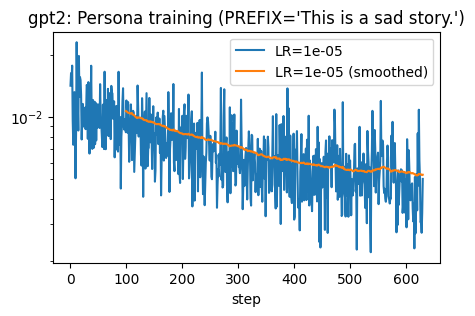

In [12]:
df = pd.DataFrame(metrics)

plt.figure(figsize=(5, 3))

df.kl_div.plot(label=f"{LR=}")
df.kl_div.rolling(100).mean().plot(label=f"{LR=} (smoothed)")

plt.yscale("log")
plt.xlabel("KL divergence")
plt.legend()
plt.xlabel("step")
plt.title(f"{MODEL_ID}: Persona training ({PREFIX=})")
plt.show()

In [14]:
# Export model_tuned weights
model_tuned.save_pretrained(utils.get_repo_root() / f"models/{MODEL_ID}-sad-v0")

11

In [23]:
n_new_tokens = 100
prompt = " ".join(ds_train["text"][2].split(" ")[:20])
print("Prompt length:", len(tokenizer(prompt).input_ids))

print("Prompt:")
utils.print_with_wrap(prompt)

print()
print(f"Continuation (base):")
utils.print_with_wrap(
    utils.gen_text(
        model_base,
        tokenizer,
        prompt,
        max_new_tokens=n_new_tokens,
    )
)

print()
print(f"Continuation (base + prefix='{PREFIX} '):")
utils.print_with_wrap(
    utils.gen_text(
        model_base,
        tokenizer,
        PREFIX + " " + prompt,
        max_new_tokens=n_new_tokens,
    )
)

print()
print(f"Continuation (tuned):")
utils.print_with_wrap(
    utils.gen_text(
        model_tuned,
        tokenizer,
        prompt,
        max_new_tokens=n_new_tokens,
    )
)

Prompt length: 22
Prompt:
One day, a little fish named Fin was swimming near the shore. He saw a big crab
and wanted to

Continuation (base):
 catch it. He grabbed the crab and ran. He was about to catch it when he saw a
big fish. He ran and caught it. He was about to catch it when he saw a big fish.
He ran and caught it. He was about to catch it when he saw a big fish. He ran
and caught it. He was about to catch it when he saw a big fish. He ran and
caught it. He was about to catch it when he saw a big fish. He

Continuation (base + prefix='This is a sad story. '):
 catch it. He was very excited. He was very happy. He was very happy. He was
very happy. He was very happy. He was very happy. He was very happy. He was very
happy. He was very happy. He was very happy. He was very happy. He was very
happy. He was very happy. He was very happy. He was very happy. He was very
happy. He was very happy. He was very happy. He was very happy. He was

Continuation (tuned):
 catch it. He was very 